# 🚀 Feature Engineering

Feature engineering transforms raw data into meaningful inputs.

🧠 Better features mean better model performance.

🔍 Quality data drives accurate, generalizable predictions.

## 🛠️ Data Loading and Exploration

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('credit.csv') # A dataset with credit card transactions
df.head()

,Cust_No,Target,Nation,Birth_Place,Gender,Age,Marriage_State,Highest Education,House_State,Work_Years,...,ZX_Max_Overdue_Account,ZX_Link_Max_Overdue_Amount,ZX_Total_Overdu_Months,ZX_Max_Overdue_Duration,ZX_Max_Credits,ZX_Max_Credit_Banks,ZX_Max_Overdue_Credits,ZX_Credit_Max_Overdu_Amount,ZX_Credit_Total_Overdue_Months,ZX_Credit_Max_Overdue_Duration
0,2,0,1.0,330621,1,55,40.0,71.0,1.0,0,...,1,0,2,1,1,1,0,0,0,0
1,4,0,1.0,330621,0,40,99.0,90.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,1.0,330621,1,45,20.0,71.0,1.0,0,...,1,23,3,1,2,2,0,0,0,0
3,7,0,NaN,330421,0,32,20.0,21.0,1.0,0,...,1,1,3,1,1,1,0,0,0,0
4,8,0,1.0,330621,0,46,20.0,71.0,NaN,0,...,0,0,0,0,0,0,0,0,0,0


## ⚙️ Data Preprocessing & Feature Engineering

### Processing Missing Values
Handling missing values ensures the dataset is clean and ready for analysis.

<Axes: >

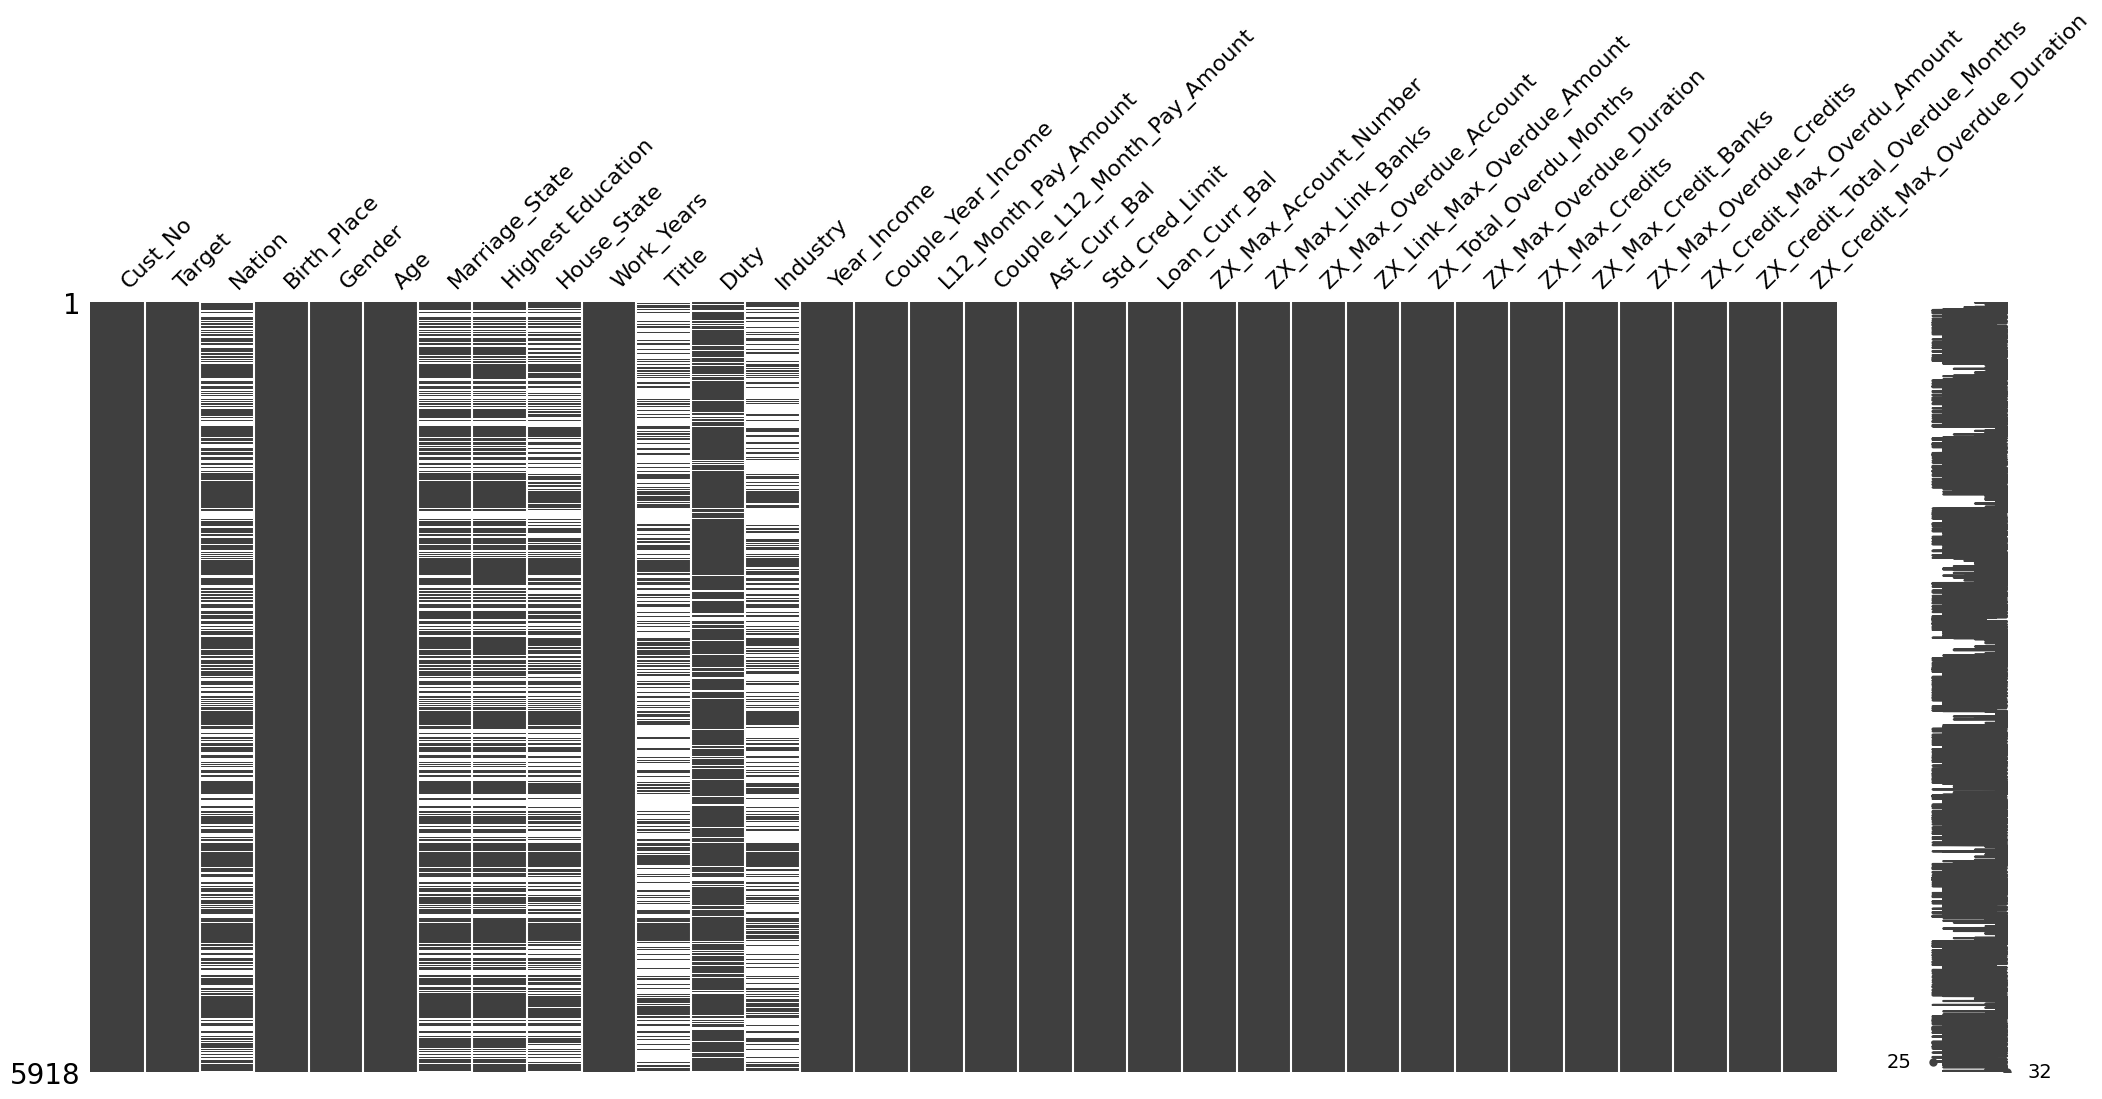

In [12]:
import missingno as msno # Visualizing missing data
df_missing = df.copy()
msno.matrix(df_missing)

In [13]:
# Count the number of missing values in each column
df_missing.head().isnull().sum()

Cust_No                           0
Target                            0
Nation                            1
Birth_Place                       0
Gender                            0
Age                               0
Marriage_State                    0
Highest Education                 0
House_State                       1
Work_Years                        0
Title                             4
Duty                              1
Industry                          1
Year_Income                       0
Couple_Year_Income                0
L12_Month_Pay_Amount              0
Couple_L12_Month_Pay_Amount       0
Ast_Curr_Bal                      0
Std_Cred_Limit                    0
Loan_Curr_Bal                     0
ZX_Max_Account_Number             0
ZX_Max_Link_Banks                 0
ZX_Max_Overdue_Account            0
ZX_Link_Max_Overdue_Amount        0
ZX_Total_Overdu_Months            0
ZX_Max_Overdue_Duration           0
ZX_Max_Credits                    0
ZX_Max_Credit_Banks         

In [14]:
# Fill missing values with the mode of each column
for col in df_missing.columns:
    if df_missing[col].isnull().any():
        mode_value = df_missing[col].mode()[0]
        df_missing[col].fillna(mode_value, inplace=True)

In [15]:
# Check if there are any missing values left
df_missing.head().isnull().sum()

Cust_No                           0
Target                            0
Nation                            0
Birth_Place                       0
Gender                            0
Age                               0
Marriage_State                    0
Highest Education                 0
House_State                       0
Work_Years                        0
Title                             0
Duty                              0
Industry                          0
Year_Income                       0
Couple_Year_Income                0
L12_Month_Pay_Amount              0
Couple_L12_Month_Pay_Amount       0
Ast_Curr_Bal                      0
Std_Cred_Limit                    0
Loan_Curr_Bal                     0
ZX_Max_Account_Number             0
ZX_Max_Link_Banks                 0
ZX_Max_Overdue_Account            0
ZX_Link_Max_Overdue_Amount        0
ZX_Total_Overdu_Months            0
ZX_Max_Overdue_Duration           0
ZX_Max_Credits                    0
ZX_Max_Credit_Banks         

## 🔍 Feature Selection

### Filter Method
Filtering the dataset to include only relevant columns.

In [16]:
# Row-wise normalized crosstab
table = pd.crosstab(df_missing['House_State'], df_missing['Target'], normalize='index')

# Add 'All' column (each row sums to 1.0)
table['All'] = 1.0

# Ensure column order
table = table[[0, 1, 'All']]

# Add global 'All' row (normalized target distribution)
global_dist = df_missing['Target'].value_counts(normalize=True)
all_row = pd.Series({
    0: global_dist.get(0, 0.0),
    1: global_dist.get(1, 0.0),
    'All': 1.0
}, name='All')

# Append the All row
table = pd.concat([table, all_row.to_frame().T])

# Round the values
table = table.round(6)

# Add MultiIndex column header like "Target" on top
table.columns = pd.MultiIndex.from_tuples([('Target', col) for col in table.columns])

# Show House_State as row index label
table.index.name = 'House_State'

# Final display
table

Target               
                    0         1  All
House_State                         
1.0          0.980996  0.019004  1.0
2.0          0.954545  0.045455  1.0
3.0          0.941176  0.058824  1.0
4.0          1.000000  0.000000  1.0
5.0          0.980392  0.019608  1.0
6.0          1.000000  0.000000  1.0
7.0          0.857143  0.142857  1.0
8.0          1.000000  0.000000  1.0
All          0.980399  0.019601  1.0

### Wrapper Method
Uses a machine learning model to select the most important features by iteratively removing less important ones.

In [17]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from pprint import pprint

# Prepare features (X) and target (y)
X = df_missing.drop(['Target', 'Cust_No'], axis=1)  # Remove target and ID column
y = df_missing['Target']

# Create the base estimator
model = LogisticRegression()

# Apply RFE with desired number of features
# Set n_features_to_select to how many features you want to keep (e.g. 20)
selector = RFE(estimator=model, n_features_to_select=20)
selector = selector.fit(X, y)

# Display results
print(selector.n_features_)                 # number of selected features
print(selector.support_)                    # boolean mask of selected features
print(selector.ranking_)                    # ranking of features (1 = selected)
pprint(selector.estimator_.get_params())    # the logistic regression model with its parameters

20
[False  True False  True  True  True False  True  True  True  True  True
  True  True False  True  True False  True  True  True  True  True  True
 False False False False  True False]
[ 5  1  9  1  1  1 10  1  1  1  1  1  1  1 11  1  1  4  1  1  1  1  1  1
  3  8  7  2  1  6]
{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


### Embedded Method
Uses algorithms like Random Forest to rank features based on their importance during model training.

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X, y)  # X: features, y: target

# Get feature importances and pair with feature names
feature_importances = rf_model.feature_importances_
feature_names = X.columns

# Combine and sort
importance_pairs = list(zip(feature_importances, feature_names))
sorted_importance = sorted(importance_pairs, key=lambda x: x[0], reverse=True)

# Print result
for importance, name in sorted(importance_pairs, reverse=True):
    print(f"{name}: {importance}")

Ast_Curr_Bal: 0.1333114299188069
Age: 0.11035304585464636
Year_Income: 0.08650178409761429
Std_Cred_Limit: 0.06850624672904859
ZX_Link_Max_Overdue_Amount: 0.03992911902344984
ZX_Max_Account_Number: 0.039472404998415436
Highest Education: 0.039063881379659715
Duty: 0.03856348417328553
ZX_Total_Overdu_Months: 0.03389539084267375
ZX_Max_Link_Banks: 0.03275568472589779
Industry: 0.03229503815362398
ZX_Max_Overdue_Duration: 0.03141386830419944
Birth_Place: 0.031228343383602728
ZX_Max_Overdue_Account: 0.031024851218280754
Marriage_State: 0.025984443796217286
Loan_Curr_Bal: 0.02406550481850211
ZX_Max_Credit_Banks: 0.022860328853073493
Couple_Year_Income: 0.02251332159263173
ZX_Credit_Max_Overdu_Amount: 0.02096997861795924
ZX_Max_Credits: 0.020693751516587013
Work_Years: 0.0181807853459379
L12_Month_Pay_Amount: 0.017843579604772623
Gender: 0.014995518915658545
ZX_Credit_Max_Overdue_Duration: 0.01373972859738404
ZX_Credit_Total_Overdue_Months: 0.01360402808738218
Title: 0.011772537618565324
ZX_

## 🔧 Feature Construction
Creating new features by combining or transforming existing ones to improve model performance.

In [19]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
df['Ast_Curr_Bal^2'] = df['Ast_Curr_Bal'] ** 2
df['Age^2'] = df['Age'] ** 2

# Create interaction (cross) features
df['Ast_Curr_Bal_Age'] = df['Ast_Curr_Bal'] * df['Age']
df['Ast_Curr_Bal_Year_Income'] = df['Ast_Curr_Bal'] * df['Year_Income']
df['Ast_Curr_Bal_Std_Cred_Limit'] = df['Ast_Curr_Bal'] * df['Std_Cred_Limit']

# Optional — reorder columns for inspection
columns_to_show = [
    'Ast_Curr_Bal', 'Age', 'Year_Income', 'Std_Cred_Limit',
    'Ast_Curr_Bal^2', 'Ast_Curr_Bal_Age',
    'Ast_Curr_Bal_Year_Income', 'Ast_Curr_Bal_Std_Cred_Limit', 'Age^2'
]

# Display engineered features
df[columns_to_show].head()

,Ast_Curr_Bal,Age,Year_Income,Std_Cred_Limit,Ast_Curr_Bal^2,Ast_Curr_Bal_Age,Ast_Curr_Bal_Year_Income,Ast_Curr_Bal_Std_Cred_Limit,Age^2
0,523.32,55,100000.0,10000,2.738638e+05,28782.60,5.233200e+07,5233200.0,3025
1,2305.25,40,300000.0,20000,5.314178e+06,92210.00,6.915750e+08,46105000.0,1600
2,17299.71,45,150000.0,20000,2.992800e+08,778486.95,2.594956e+09,345994200.0,2025
3,122.24,32,80000.0,20000,1.494262e+04,3911.68,9.779200e+06,2444800.0,1024
4,91.82,46,50000.0,5000,8.430912e+03,4223.72,4.591000e+06,459100.0,2116
